In [1]:
import platform
import requests
from pathlib import Path

%pip install -q "git+https://github.com/huggingface/optimum-intel.git" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q -U  "openvino>=2025.0" "openvino-tokenizers>=2025.0" "openvino-genai>=2025.0" "nncf>=2.14.0"
%pip install -q Pillow "diffusers>=0.30.3" "gradio>=4.19" "typing_extensions>=4.9" "tqdm" huggingface-hub  --extra-index-url https://download.pytorch.org/whl/cpu

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )
    open("cmd_helper.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("inpainting-genai.ipynb")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 M

<frozen importlib.util>:262: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.


In [2]:
from cmd_helper import optimum_cli

inpaint_model_id = "stable-diffusion-v1-5/stable-diffusion-inpainting"

inpaint_model_dir = Path(inpaint_model_id.split("/")[-1] + "-int8-ov")

if not inpaint_model_dir.exists():
    optimum_cli(inpaint_model_id, inpaint_model_dir, additional_args={"weight-format": "int8"})

**Export command:**

`optimum-cli export openvino --model stable-diffusion-v1-5/stable-diffusion-inpainting stable-diffusion-inpainting-int8-ov --weight-format int8`

In [4]:
from notebook_utils import device_widget


device = device_widget("CPU", exclude=["NPU", "AUTO"])
device

Dropdown(description='Device:', options=('CPU',), value='CPU')

In [5]:
import openvino_genai as ov_genai

pipe = ov_genai.InpaintingPipeline(inpaint_model_dir, device.value)

In [6]:
from diffusers.utils import load_image, make_image_grid

image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png"
mask_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png"

init_image_path = Path("inpaint.png")
mask_path = Path("inpaint_mask.png")

if not init_image_path.exists():
    load_image(image_url).save(init_image_path)

if not mask_path.exists():
    load_image(mask_url).save(mask_path)

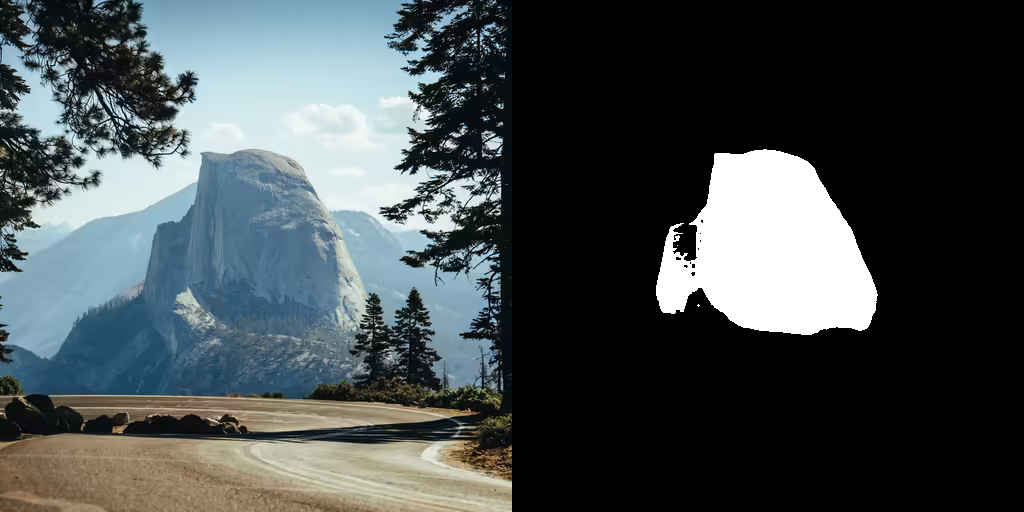

In [7]:
import openvino as ov
import numpy as np
from PIL import Image


def image_to_tensor(image: Image) -> ov.Tensor:
    pic = image.convert("RGB")
    image_data = np.array(pic.getdata()).reshape(1, pic.size[1], pic.size[0], 3).astype(np.uint8)
    return ov.Tensor(image_data)


init_image = Image.open(init_image_path)
init_image_tensor = image_to_tensor(init_image)

mask_image = Image.open(mask_path)
mask_image_tensor = image_to_tensor(mask_image)

make_image_grid([init_image, mask_image], rows=1, cols=2)

0it [00:00, ?it/s]

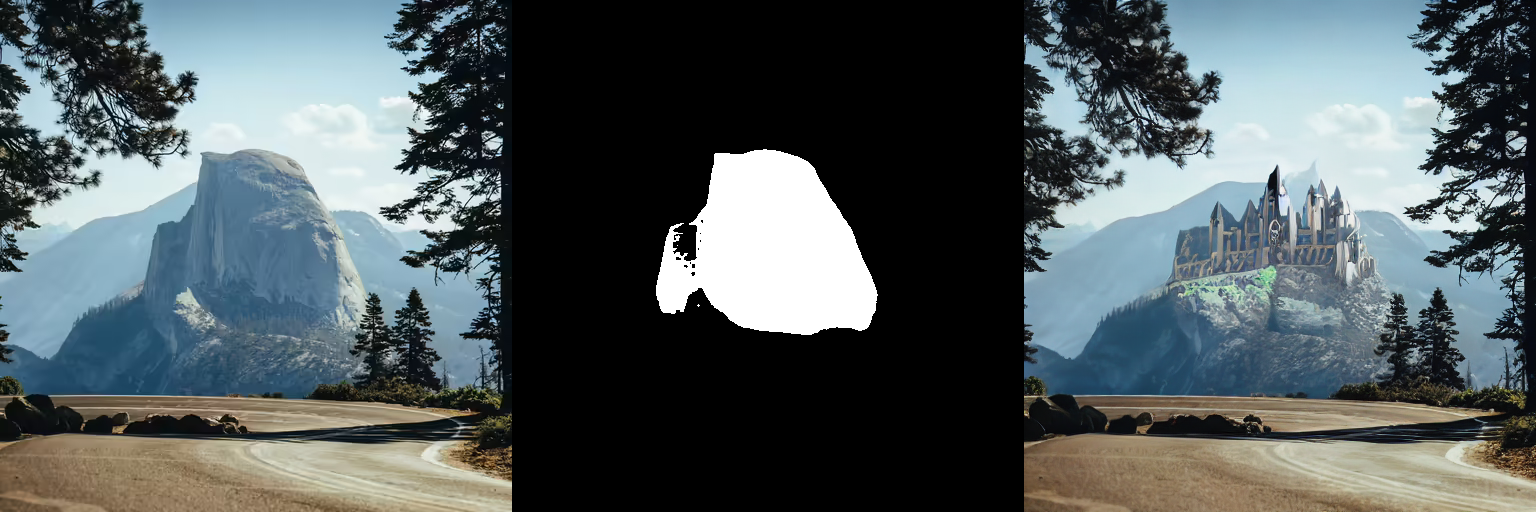

In [8]:
from tqdm.notebook import tqdm
import sys

generator = ov_genai.TorchGenerator(92)
prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"

pbar = tqdm()


def callback(step, num_steps, latent):
    if pbar.total is None:
        pbar.reset(num_steps)
    pbar.update(1)
    sys.stdout.flush()
    return False


image_tensor = pipe.generate(prompt, init_image_tensor, mask_image_tensor, generator=generator, callback=callback, num_inference_steps=20)

pbar.close()
out_image = Image.fromarray(image_tensor.data[0])

make_image_grid([init_image, mask_image, out_image], rows=1, cols=3)